In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
path = '../results/metrics/'
model = 'Graph_RelNet' # 'RelNet
seed = 0
snr = 5 # 30, 100
array = 'random' # BK

method = f"{model}_seed_{seed}"
# method = 'delay_and_sum'

test = pd.read_csv(path + method + '_SNR_' + str(snr) + '_' + array + '_results.csv')

test.head()

,best_test_maae,best_test_az_maae,best_test_el_maae,val_maae,val_az_maae,val_el_maae,num_mics_per_array,val_maae_per_array,val_az_maae_per_array,val_el_maae_per_array
0,3.14836,3.761729,2.534991,11.605022,13.155975,10.05407,"[4, 5, 6, 7]","{""4"": 13.768317222595215, ""5"": 8.9564142227172...","{""4"": 15.020891189575195, ""5"": 12.090023040771...","{""4"": 12.515742301940918, ""5"": 5.8228054046630..."


In [4]:
# Grouped bar plot: val_maae vs number of microphones for a given array and SNR, comparing RelNet vs Graph-RelNet, optionally with DAS baseline
import json
from collections import defaultdict
from typing import Iterable, Dict, List, Tuple, Optional

def plot_val_maae_by_mics(
    array: str,
    snr: int,
    path: str = path,
    models: Tuple[str, str] = ("RelNet", "Graph-RelNet"),
    seeds: Iterable[int] = range(5),
    mic_filter: Optional[List[int]] = None,
    include_das: bool = True,
):
    """
    Plot grouped bars of MAAE per number of mics for the given array and SNR.

    Bars per mic (left to right):
      - DAS (delay-and-sum) per-array MAAE (no STD, single run)
      - RelNet mean MAAE across seeds (with STD error bar)
      - Graph-RelNet mean MAAE across seeds (with STD error bar)

    Parameters
    ----------
    array : str
        One of {"BK", "random"}.
    snr : int
        One of {100, 30, 5}.
    path : str
        Directory containing results CSVs.
    models : (str, str)
        Pair of model names to compare (seeded models).
    seeds : Iterable[int]
        Seeds to average over for seeded models.
    mic_filter : Optional[List[int]]
        If provided, only plot these mic counts (in this order if present in data).
    include_das : bool
        If True, try to load `delay_and_sum_SNR_{snr}_{array}_results.csv` and plot as baseline.
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    # Set font sizes for single-column figure
    plt.rcParams.update({
        'font.size': 8,
        'axes.labelsize': 8,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
    })

    def collect_model(array: str, snr: int, model: str, seeds: Iterable[int]) -> Dict[int, List[float]]:
        per_mic: Dict[int, List[float]] = defaultdict(list)
        for seed in seeds:
            # Accept both Graph-RelNet and Graph_RelNet for backward compatibility
            model_file = model.replace("-", "_") if model == "Graph-RelNet" else model
            file = os.path.join(path, f"{model_file}_seed_{seed}_SNR_{snr}_{array}_results.csv")
            try:
                df = pd.read_csv(file)
                d = json.loads(df["val_maae_per_array"].iloc[0])
            except FileNotFoundError:
                continue
            except Exception:
                # Skip problematic entries gracefully
                continue
            for k, v in d.items():
                try:
                    per_mic[int(k)].append(float(v))
                except Exception:
                    continue
        return per_mic

    def collect_das(array: str, snr: int) -> Dict[int, float]:
        """Return DAS per-array MAAE mapping mic->value if available, else {}."""
        das_map: Dict[int, float] = {}
        file = os.path.join(path, f"delay_and_sum_SNR_{snr}_{array}_results.csv")
        try:
            df = pd.read_csv(file)
            # Expect column 'maae_per_array' containing JSON-like dict
            d = df.get("maae_per_array")
            if d is None:
                return {}
            d = json.loads(d.iloc[0])
            for k, v in d.items():
                try:
                    das_map[int(k)] = float(v)
                except Exception:
                    continue
        except FileNotFoundError:
            return {}
        except Exception:
            return {}
        return das_map

    relnet_name, graph_name = models
    relnet = collect_model(array, snr, relnet_name, seeds)
    graph = collect_model(array, snr, graph_name, seeds)
    das = collect_das(array, snr) if include_das else {}

    # Means and STDs per mic (STD across seeds; use ddof=1 if >=2 samples else 0)
    def mean_std(d: Dict[int, List[float]]):
        m = {}
        s = {}
        for k, vals in d.items():
            if len(vals) == 0:
                continue
            m[k] = float(np.mean(vals))
            if len(vals) >= 2:
                s[k] = float(np.std(vals, ddof=1))
            else:
                s[k] = 0.0
        return m, s

    relnet_mean, relnet_std = mean_std(relnet)
    graph_mean, graph_std = mean_std(graph)

    # Align mic keys across available sources
    keys_union = set(relnet_mean) | set(graph_mean) | set(das)
    if mic_filter:
        mic_counts = [m for m in mic_filter if m in keys_union]
    else:
        mic_counts = sorted(keys_union)

    if len(mic_counts) == 0:
        raise ValueError("No mic counts found from the provided data.")

    das_vals = [das.get(k, np.nan) for k in mic_counts]
    rel_vals = [relnet_mean.get(k, np.nan) for k in mic_counts]
    gra_vals = [graph_mean.get(k, np.nan) for k in mic_counts]
    rel_errs = [relnet_std.get(k, 0.0) for k in mic_counts]
    gra_errs = [graph_std.get(k, 0.0) for k in mic_counts]

    # Plot
    x = np.arange(len(mic_counts))
    n_bars = 3 if (include_das and len(das) > 0) else 2
    total_width = 0.75
    width = total_width / n_bars
    if n_bars == 3:
        offsets = (-width, 0.0, +width)
        hatches = ['////', '......', 'xxxx']  # DAS, RelNet, Graph-RelNet (finer patterns)
    else:
        offsets = (-width/2, +width/2)
        hatches = ['......', 'xxxx']  # RelNet, Graph-RelNet

    # Set figure size for single-column IEEE (about 3.5 inches wide)
    fig, ax = plt.subplots(figsize=(3.5, 2.5))

    # Consistent bar colors and error bar style
    das_color = "#59A14F"
    relnet_color = "#4E79A7"
    graph_color = "#F28E2B"
    error_kw = dict(capsize=5, capthick=0.75, elinewidth=0.75, ecolor="#000000")

    # Set smaller line width for hatching
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#444444'

    # DAS bar (no error bars)
    if include_das and len(das) > 0:
        bars_das = ax.bar(
            x + offsets[0],
            das_vals,
            width,
            label="Delay-and-sum",
            color=das_color,
            hatch=hatches[0],
        )
        rel_offset, gra_offset = offsets[1], offsets[2]
        rel_hatch, gra_hatch = hatches[1], hatches[2]
    else:
        rel_offset, gra_offset = offsets[0], offsets[1]
        rel_hatch, gra_hatch = hatches[0], hatches[1]

    # RelNet and Graph-RelNet with error bars
    bars_rel = ax.bar(
        x + rel_offset,
        rel_vals,
        width,
        yerr=rel_errs,
        label=relnet_name,
        color=relnet_color,
        error_kw=error_kw,
        hatch=rel_hatch,
    )
    bars_gra = ax.bar(
        x + gra_offset,
        gra_vals,
        width,
        yerr=gra_errs,
        label="Graph-RelNet\n(proposed method)",
        color=graph_color,
        error_kw=error_kw,
        hatch=gra_hatch,
    )

    # Remove the image title
    # ax.set_title(f"MAE on test set, SNR = {snr} dB", pad=4)  # Removed
    ax.set_xlabel("Number of microphones", labelpad=2)
    ax.set_ylabel("MAE [°]", labelpad=2)

    # Set custom x-tick labels: 4 mics, 6 mics, 7 mics
    xtick_labels = []
    for k in mic_counts:
        xtick_labels.append(f"{k}")

    ax.set_xticks(x)
    ax.set_xticklabels(xtick_labels)
    # Make legend background non-transparent
    ax.legend(loc='lower left', framealpha=1.0)
    ax.grid(axis="y", linestyle=":", alpha=0.5)
    # Use tight_layout with small pad to reduce whitespace
    fig.tight_layout(pad=0.5)
    return fig, ax

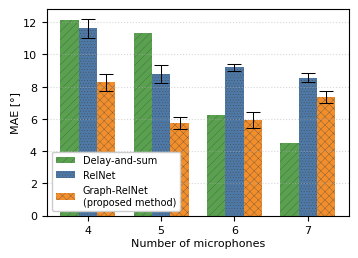

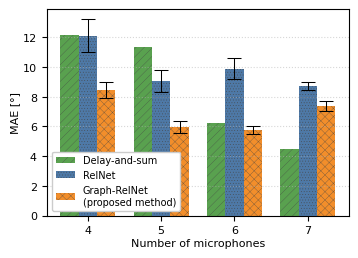

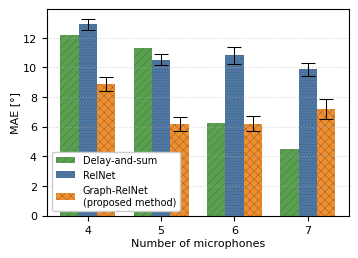

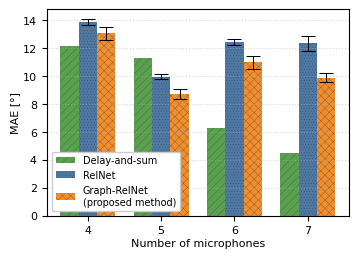

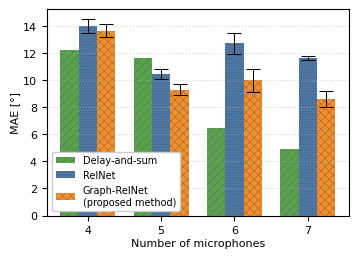

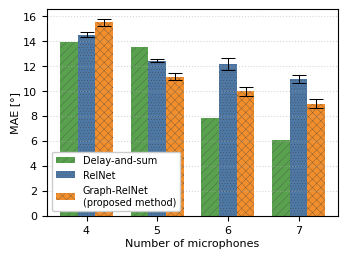

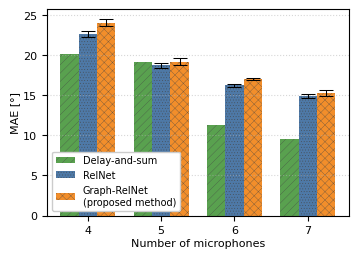

In [9]:
# Render plot with DAS baseline (if available) for a chosen array and SNR
# fig, ax = plot_val_maae_by_mics(array="random", snr=5, include_das=True)
# plt.show()

for snr in [100, 60, 30, 5, 0, -5, -10]:
    fig, ax = plot_val_maae_by_mics(array="random", snr=snr, include_das=True)
    # plt.show()
    fig.savefig(f"../results/plots/maae/MAE_SNR_{snr}.png", dpi = 500)

In [10]:
# Plot overall MAE for different SNRs as a grouped bar plot for DAS, RelNet, and Graph-RelNet (DAS left, then RelNet, then Graph-RelNet; SNRs left=lowest, right=highest)
def plot_overall_maae_vs_snr_multi(array="random", models=("RelNet", "Graph-RelNet"), seeds=range(5), snrs=[-10, -5, 0, 5, 30, 100], path=path, include_das=True):
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    import json
    import matplotlib

    # Set font sizes for single-column figure
    plt.rcParams.update({
        'font.size': 8,
        'axes.labelsize': 8,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
    })

    n_snrs = len(snrs)
    n_bars = 3 if include_das else 2
    width = 0.25 if include_das else 0.28
    error_kw = dict(capsize=4, capthick=0.75, elinewidth=0.75, ecolor="#000000")
    x = np.arange(n_snrs)

    maes = {m: [] for m in models}
    maes_std = {m: [] for m in models}
    das_maes = [] if include_das else None

    for snr in snrs:
        # For each model
        for m in models:
            vals = []
            model_file = m.replace("-", "_") if m == "Graph-RelNet" else m
            for seed in seeds:
                file = os.path.join(path, f"{model_file}_seed_{seed}_SNR_{snr}_{array}_results.csv")
                try:
                    df = pd.read_csv(file)
                    if "val_maae" in df.columns:
                        vals.append(float(df["val_maae"].iloc[0]))
                    elif "maae" in df.columns:
                        vals.append(float(df["maae"].iloc[0]))
                except Exception:
                    continue
            if vals:
                maes[m].append(np.mean(vals))
                maes_std[m].append(np.std(vals, ddof=1) if len(vals) > 1 else 0.0)
            else:
                maes[m].append(np.nan)
                maes_std[m].append(0.0)
        # DAS
        if include_das:
            das_file = os.path.join(path, f"delay_and_sum_SNR_{snr}_{array}_results.csv")
            try:
                das_df = pd.read_csv(das_file)
                if "val_maae" in das_df.columns:
                    das_maes.append(float(das_df["val_maae"].iloc[0]))
                elif "maae" in das_df.columns:
                    das_maes.append(float(das_df["maae"].iloc[0]))
                else:
                    das_maes.append(np.nan)
            except Exception:
                das_maes.append(np.nan)

    # Set figure size for single-column IEEE (about 3.5 inches wide)
    fig, ax = plt.subplots(figsize=(3.5, 2.5))
    offsets = np.array([-width, 0, width]) if include_das else np.array([-width/2, width/2])

    # Apply same hatching patterns and line width as previous cell
    if include_das:
        hatches = ['////', '......', 'xxxx']  # DAS, RelNet, Graph-RelNet
    else:
        hatches = ['......', 'xxxx']  # RelNet, Graph-RelNet
    matplotlib.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#444444'

    # Plot bars for each SNR group: left=DAS, mid=RelNet, right=Graph-RelNet
    if include_das:
        bars_das = ax.bar(x + offsets[0], das_maes, width, label="Delay-and-sum", color="#59A14F", hatch=hatches[0])
        bars_rel = ax.bar(x + offsets[1], maes[models[0]], width, yerr=maes_std[models[0]], label=models[0].replace("_", "-"), color="#4E79A7", error_kw=error_kw, hatch=hatches[1])
        bars_gra = ax.bar(x + offsets[2], maes[models[1]], width, yerr=maes_std[models[1]], label="Graph-RelNet\n(proposed method)", color="#F28E2B", error_kw=error_kw, hatch=hatches[2])
    else:
        bars_rel = ax.bar(x + offsets[0], maes[models[0]], width, yerr=maes_std[models[0]], label=models[0].replace("_", "-"), color="#4E79A7", error_kw=error_kw, hatch=hatches[0])
        bars_gra = ax.bar(x + offsets[1], maes[models[1]], width, yerr=maes_std[models[1]], label="Graph-RelNet\n(proposed method)", color="#F28E2B", error_kw=error_kw, hatch=hatches[1])

    ax.set_xticks(x)
    ax.set_xticklabels([str(s) for s in snrs])
    ax.set_xlabel("SNR [dB]", labelpad=2)
    ax.set_ylabel("MAE [°]", labelpad=2)
    # Remove the image title
    # ax.set_title(f"MAE on test set", pad=4)  # Removed
    ax.set_yticks([0, 2, 4, 6, 8, 10, 12])
    ax.legend(loc='lower left', framealpha=1.0)
    ax.grid(axis="y", linestyle=":", alpha=0.5)
    fig.tight_layout(pad=0.5)
    return fig, ax

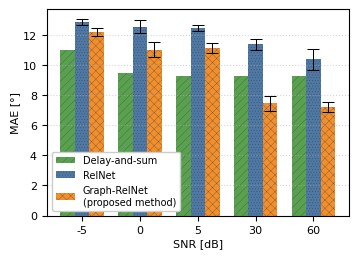

In [11]:
# Example usage: plot overall MAAE for RelNet, Graph_RelNet, and D&S for different SNRs (left=lowest SNR, right=highest)
# fig, ax = plot_overall_maae_vs_snr_multi(array="random", models=("RelNet", "Graph_RelNet"), include_das=True, snrs = [-10, -5, 0, 5, 30, 100])
fig, ax = plot_overall_maae_vs_snr_multi(array="random", models=("RelNet", "Graph_RelNet"), include_das=True, snrs = [-5, 0, 5, 30, 60])
# plt.show()
fig.savefig(f"../results/plots/maae/overall_MAE_vs_SNR.png", dpi = 500)

In [ ]:
# Triplet bar plot: overall val_MAAE, val_az_MAAE, val_el_MAAE for DAS (optional), RelNet, Graph_RelNet
from typing import Iterable, Dict, List, Tuple, Optional

def plot_overall_val_maae_triplet(
    array: str,
    snr: int,
    results_path: Optional[str] = None,
    models: Tuple[str, str] = ("RelNet", "Graph_RelNet"),
    seeds: Iterable[int] = range(5),
    include_das: bool = True,
    layout: str = "row",  # "row" -> 1x3, "col" -> 3x1
):
    """
    Plot three bar charts: overall MAAE, azimuth MAAE, elevation MAAE using only scalar metrics.

    Bars (left->right) per chart:
      - D&S average (if include_das=True and file present; no error bars)
      - RelNet (mean across seeds, with STD error bar)
      - Graph_RelNet (mean across seeds, with STD error bar)

    Scalar columns tried (in order):
      - Overall:  val_maae, maae
      - Azimuth:  val_az_maae, az_maae
      - Elevation: val_el_maae, el_maae
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    # Consistent bar colors and error bar style
    das_color = "#59A14F"
    relnet_color = "#4E79A7"
    graph_color = "#F28E2B"
    error_kw = dict(capsize=5, linewidth=1.5, ecolor="#000000")

    # Resolve results_path robustly
    if results_path is None:
        try:
            results_path = path  # type: ignore[name-defined]
        except NameError:
            results_path = "../results/metrics/telfor/"

    def _get_scalar(df, candidates: List[str]) -> Optional[float]:
        for c in candidates:
            if c in df.columns:
                try:
                    return float(df[c].iloc[0])
                except Exception:
                    try:
                        return float(df[c])
                    except Exception:
                        continue
        return None

    def load_seeded_scalars(model: str) -> Dict[str, List[float]]:
        acc = {"maae": [], "az": [], "el": []}
        for seed in seeds:
            file = os.path.join(results_path, f"{model}_seed_{seed}_SNR_{snr}_{array}_results.csv")
            try:
                import pandas as pd
                df = pd.read_csv(file)
            except Exception:
                continue
            maae = _get_scalar(df, ["val_maae", "maae"])
            az = _get_scalar(df, ["val_az_maae", "az_maae"])
            el = _get_scalar(df, ["val_el_maae", "el_maae"])
            if maae is not None:
                acc["maae"].append(maae)
            if az is not None:
                acc["az"].append(az)
            if el is not None:
                acc["el"].append(el)
        return acc

    def load_das_scalars() -> Optional[Dict[str, Optional[float]]]:
        file = os.path.join(results_path, f"delay_and_sum_SNR_{snr}_{array}_results.csv")
        try:
            import pandas as pd
            df = pd.read_csv(file)
        except Exception:
            return None
        return {
            "maae": _get_scalar(df, ["val_maae", "maae"]),
            "az": _get_scalar(df, ["val_az_maae", "az_maae"]),
            "el": _get_scalar(df, ["val_el_maae", "el_maae"]),
        }

    relnet_name, graph_name = models
    rel_acc = load_seeded_scalars(relnet_name)
    gra_acc = load_seeded_scalars(graph_name)
    das_acc = load_das_scalars() if include_das else None

    def mean_std(vals: List[float]) -> Tuple[Optional[float], float]:
        if len(vals) == 0:
            return None, 0.0
        if len(vals) == 1:
            return float(vals[0]), 0.0
        return float(np.mean(vals)), float(np.std(vals, ddof=1))

    rel_m, rel_s = mean_std(rel_acc["maae"])
    rel_az_m, rel_az_s = mean_std(rel_acc["az"])
    rel_el_m, rel_el_s = mean_std(rel_acc["el"])

    gra_m, gra_s = mean_std(gra_acc["maae"])
    gra_az_m, gra_az_s = mean_std(gra_acc["az"])
    gra_el_m, gra_el_s = mean_std(gra_acc["el"])

    # Decide once whether to show DAS slot across all subplots
    show_das = include_das and (das_acc is not None)

    # Build labels/colors (consistent across subplots)
    if show_das:
        labels = ["Delay-and-sum", relnet_name, graph_name]
        colors = [das_color, relnet_color, graph_color]
    else:
        labels = [relnet_name, graph_name]
        colors = [relnet_color, graph_color]

    def build_vals_errs(das_v: Optional[float], rel_v: Optional[float], gra_v: Optional[float], rel_std: float, gra_std: float):
        vals: List[float] = []
        errs: List[Optional[float]] = []
        if show_das:
            vals.append(das_v if das_v is not None else np.nan)
            errs.append(None)  # no error bars for D&S
        vals.append(rel_v if rel_v is not None else np.nan)
        errs.append(rel_std if rel_v is not None else 0.0)
        vals.append(gra_v if gra_v is not None else np.nan)
        errs.append(gra_std if gra_v is not None else 0.0)
        if not show_das:
            vals = vals[1:]
            errs = errs[1:]
        return vals, errs

    maae_vals, maae_errs = build_vals_errs(
        (das_acc or {}).get("maae") if show_das else None,
        rel_m,
        gra_m,
        rel_s,
        gra_s,
    )
    az_vals, az_errs = build_vals_errs(
        (das_acc or {}).get("az") if show_das else None,
        rel_az_m,
        gra_az_m,
        rel_az_s,
        gra_az_s,
    )
    el_vals, el_errs = build_vals_errs(
        (das_acc or {}).get("el") if show_das else None,
        rel_el_m,
        gra_el_m,
        rel_el_s,
        gra_el_s,
    )

    # Determine a common y-limit across subplots (consider error bars for Rel/Graph)
    def max_with_err(vals: List[float], errs: List[Optional[float]]) -> float:
        m = 0.0
        for v, e in zip(vals, errs):
            if v is None or (isinstance(v, float) and np.isnan(v)):
                continue
            err = float(e) if isinstance(e, (int, float)) else 0.0
            up = float(v) + err
            if up > m:
                m = up
        return m

    y_upper = max(
        max_with_err(maae_vals, maae_errs),
        max_with_err(az_vals, az_errs),
        max_with_err(el_vals, el_errs),
)
    if y_upper <= 0:
        y_upper = 1.0
    y_upper *= 1.1  # small headroom

    # Choose layout
    if layout == "col":
        nrows, ncols = 3, 1
        figsize = (6.5, 10.0)
    else:  # row
        nrows, ncols = 1, 3
        figsize = (13.0, 4.5)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)

    def draw(ax, vals, errs, title, draw_ylabel: bool = True):
        x = np.arange(len(vals))
        for i in range(len(vals)):
            is_das = (show_das and i == 0)  # first bar is D&S when present
            if is_das:
                ax.bar(x[i], vals[i], color=das_color)  # no yerr for D&S
            elif i == 1 or (not show_das and i == 0):
                ax.bar(x[i], vals[i], yerr=errs[i], color=relnet_color, error_kw=error_kw)
            else:
                ax.bar(x[i], vals[i], yerr=errs[i], color=graph_color, error_kw=error_kw)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set_title(title)
        if draw_ylabel:
            ax.set_ylabel("MAAE on validation set")
        ax.set_ylim(0, y_upper)
        ax.grid(axis="y", linestyle=":", alpha=0.5)

    draw(axs[0, 0], maae_vals, maae_errs, "Overall")
    if layout == "col":
        draw(axs[1, 0], az_vals, az_errs, "Azimuth", draw_ylabel=False)
        draw(axs[2, 0], el_vals, el_errs, "Elevation", draw_ylabel=False)
    else:
        draw(axs[0, 1], az_vals, az_errs, "Azimuth", draw_ylabel=False)
        draw(axs[0, 2], el_vals, el_errs, "Elevation", draw_ylabel=False)

    fig.suptitle(f"Overal MAAE\nArray = {array}, SNR = {snr} dB")
    fig.tight_layout()
    return fig, axs

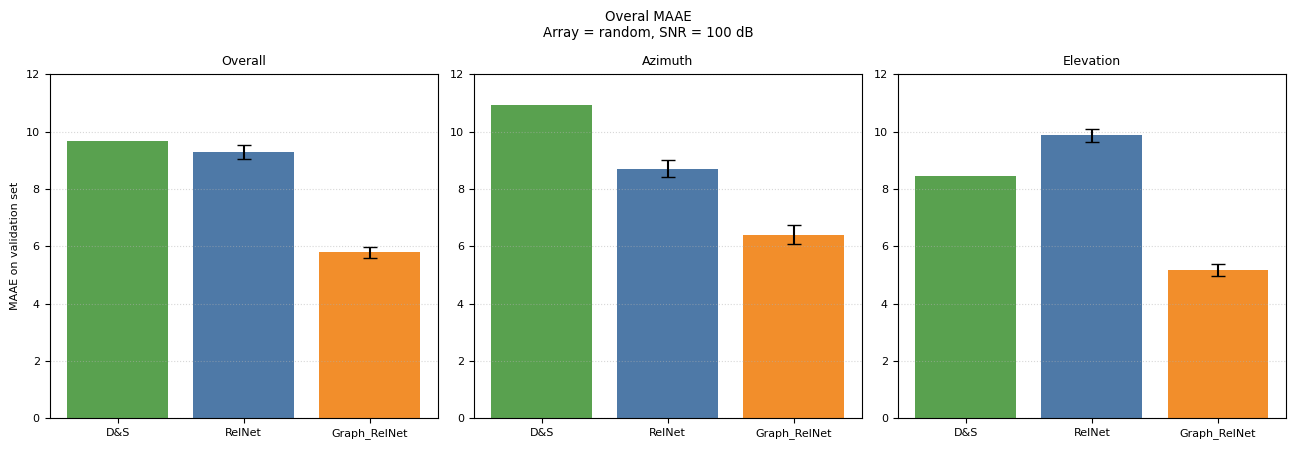

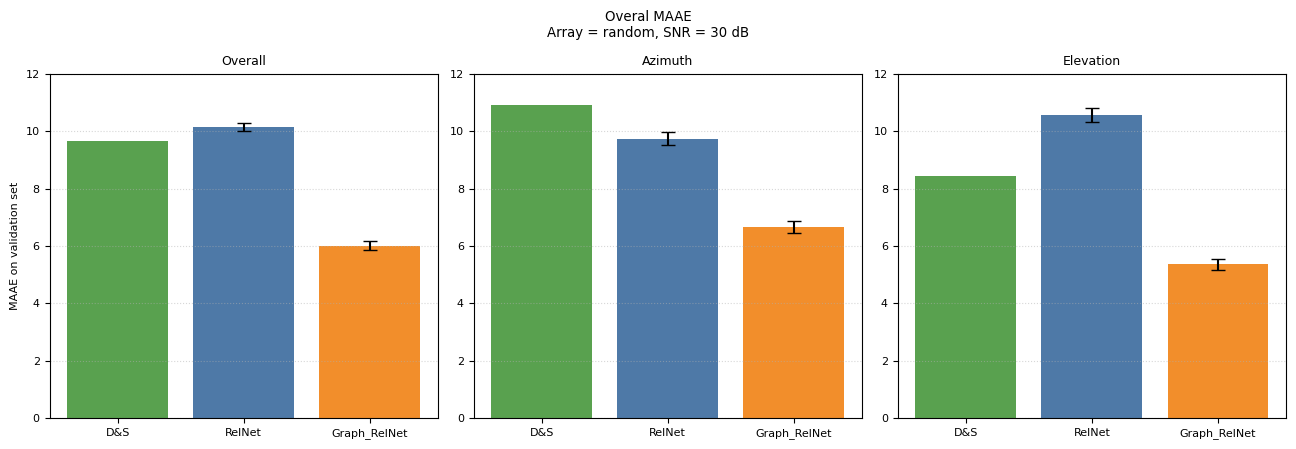

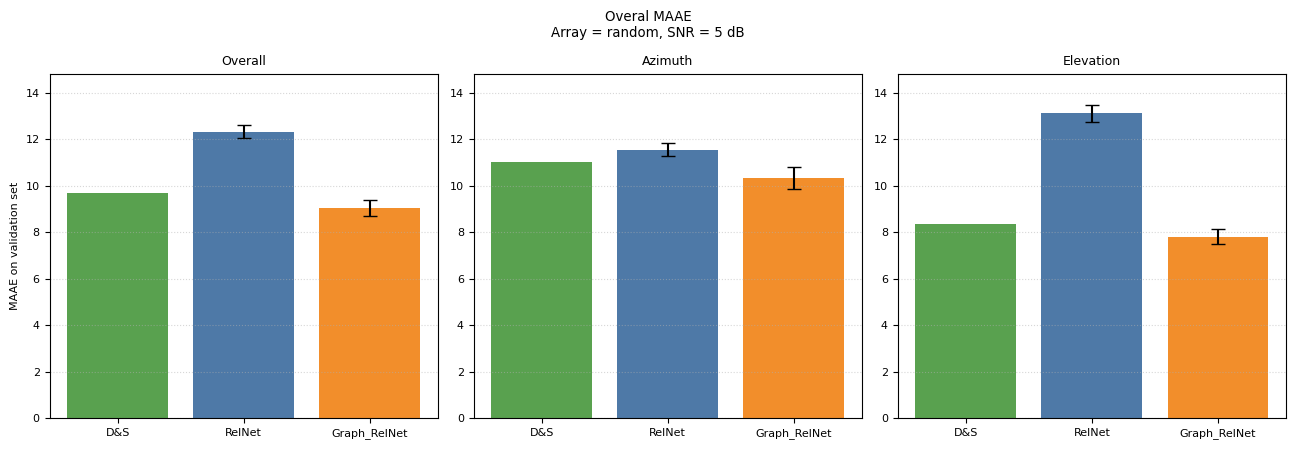

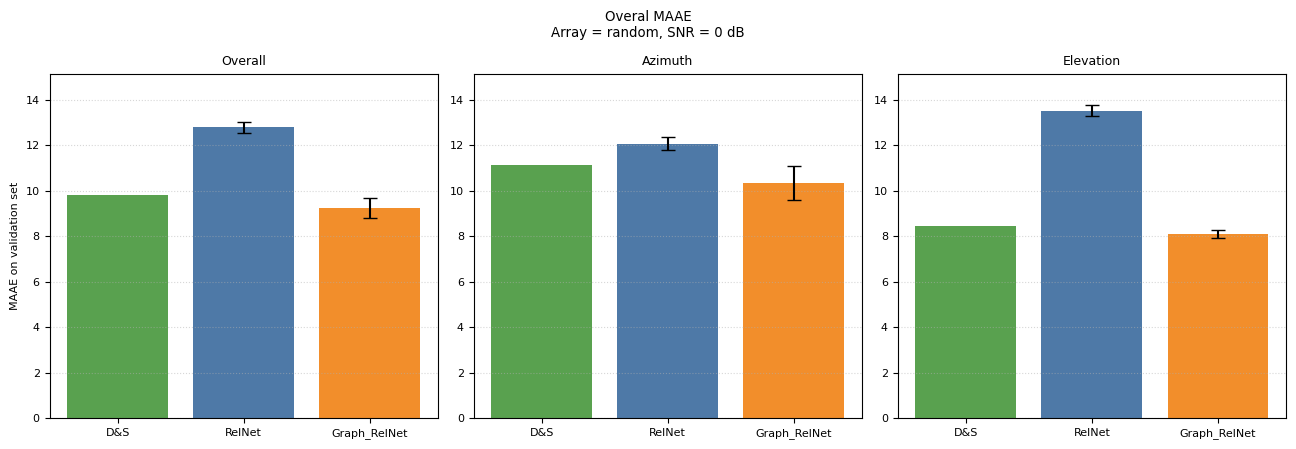

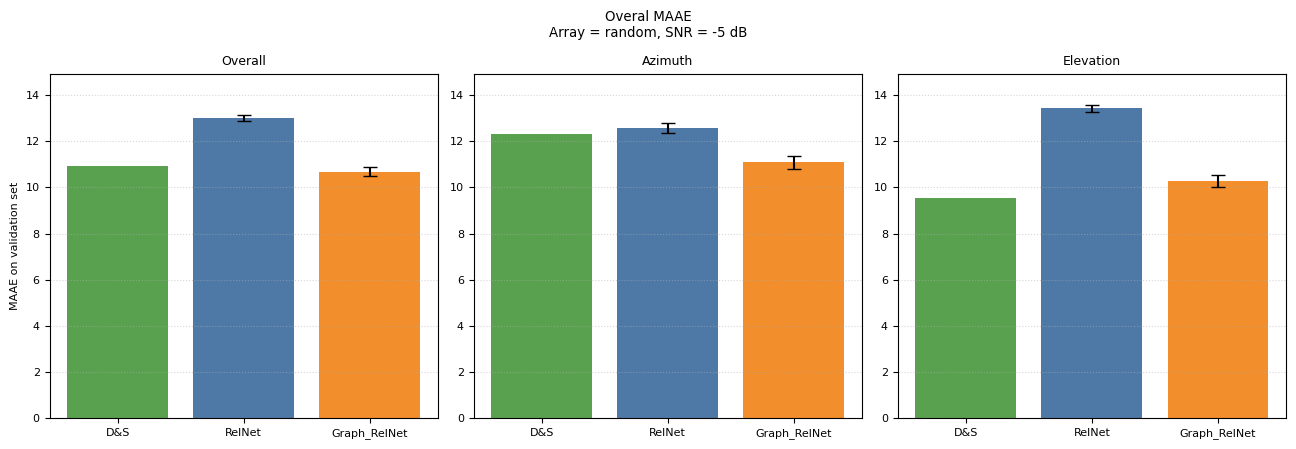

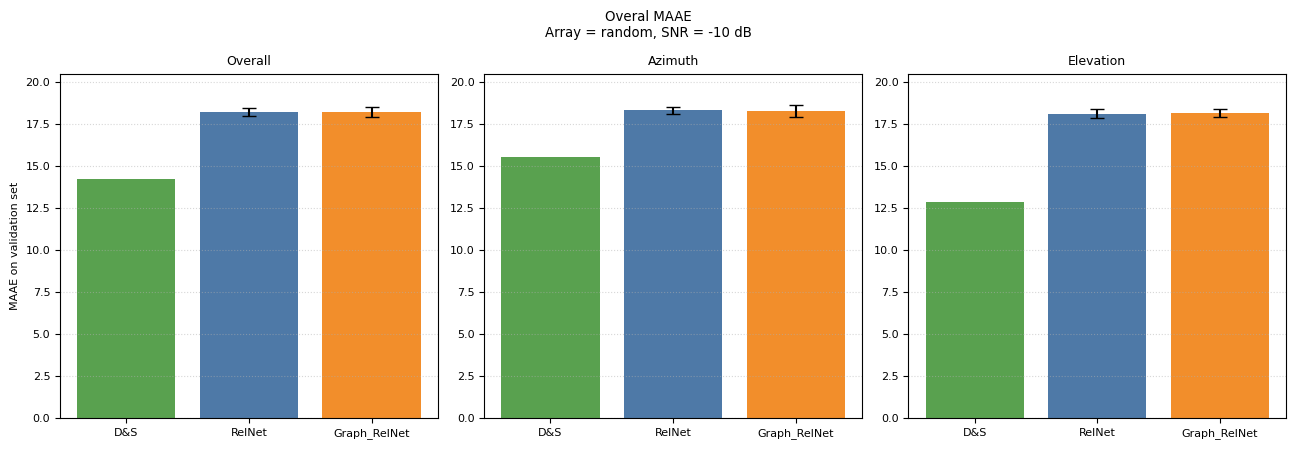

In [131]:
# Example usage: overall + az/el triplet bars
# fig, axs = plot_overall_val_maae_triplet(array='random', snr=5, include_das=True, layout="row")
# plt.show()

for snr in [100, 30, 5, 0, -5, -10]:
    fig, ax = plot_overall_val_maae_triplet(array="random", snr=snr, include_das=True, layout="row")
    plt.show()
    # fig.savefig(f"../results/plots/maae/overall_az_el_MAAE_SNR_{snr}.png", dpi = 300)

In [ ]:
# JUNK

#
#
#
#
#

import json
from collections import defaultdict

for array in ['random']:
    for snr in [100, 30, 5, 0, -5]:
        for model in ['RelNet', 'Graph_RelNet']:

            val_maaes = []
            val_az_maaes = []
            val_el_maaes = []

            val_maae_per_array_accum = defaultdict(list)
            val_az_maae_per_array_accum = defaultdict(list)
            val_el_maae_per_array_accum = defaultdict(list)

            for seed in [0, 1, 2, 3, 4]:
                csv = pd.read_csv(path + model + '_seed_' + str(seed) + '_SNR_' + str(snr) + '_' + array + '_results.csv')

                val_maaes.append(csv['val_maae'])
                val_az_maaes.append(csv['val_az_maae'])
                val_el_maaes.append(csv['val_el_maae'])

                # Parse the JSON-like string to a dictionary for val_maae_per_array
                val_maae_dict = json.loads(csv['val_maae_per_array'].iloc[0])
                for k, v in val_maae_dict.items():
                    val_maae_per_array_accum[k].append(v)

                # Parse and accumulate for val_az_maae_per_array
                val_az_maae_dict = json.loads(csv['val_az_maae_per_array'].iloc[0])
                for k, v in val_az_maae_dict.items():
                    val_az_maae_per_array_accum[k].append(v)

                # Parse and accumulate for val_el_maae_per_array
                val_el_maae_dict = json.loads(csv['val_el_maae_per_array'].iloc[0])
                for k, v in val_el_maae_dict.items():
                    val_el_maae_per_array_accum[k].append(v)

            avg_val_maae = np.mean(val_maaes)
            avg_val_az_maae = np.mean(val_az_maaes)
            avg_val_el_maae = np.mean(val_el_maaes)

            # Compute the average for each key:
            avg_val_maae_per_array = {k: np.mean(v) for k, v in val_maae_per_array_accum.items()}
            avg_val_az_maae_per_array = {k: np.mean(v) for k, v in val_az_maae_per_array_accum.items()}
            avg_val_el_maae_per_array = {k: np.mean(v) for k, v in val_el_maae_per_array_accum.items()}